# Investigating the differences between men and women's emails and how often they apologize, put themselves down, and more

In [308]:
import pandas as pd
import numpy as np
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
nltk.download('punkt')

import matplotlib.pyplot as plt
from scipy import stats
#!pip install wordcloud
from wordcloud import WordCloud, STOPWORDS
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

import itertools

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\baile\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\baile\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


### Clean the data

In [14]:
enron_emails = pd.read_csv('clean_enron_emails.csv')
enron_emails = enron_emails.drop(columns = ['Unnamed: 0', 'Unnamed: 0.1', 'text_tokens', 'text'])

In [15]:
enron_emails['clean_text'] = [row.lower() for row in enron_emails['clean_text']]

In [16]:
stop_words = set(stopwords.words('english'))
print(stop_words)

{'ourselves', 'am', 's', 'your', 'then', 'weren', 'we', 'shouldn', 'can', 'these', "weren't", 'his', 'down', 'because', "you'll", 'does', 'here', 'again', 'now', 'once', "it's", 'very', 'before', "that'll", 'when', 'd', 'shan', "you've", 'itself', 'o', "isn't", 'y', 'their', 'the', 'he', 'himself', 'against', 'if', 'over', 'ours', 'in', 'until', 'further', 'me', 'herself', 'don', 'should', 'an', 'as', 'whom', 'aren', 'our', 'to', 'only', 'them', 'her', 'she', 'off', 'my', "hadn't", 'do', "couldn't", 'who', 'this', 'hadn', 'ma', "didn't", 'myself', "needn't", "wouldn't", 'with', 'didn', 'too', 'was', 'which', 'doing', "should've", 'being', "mustn't", 'ain', 'just', 'wouldn', "hasn't", "aren't", 'yourself', 'where', 'i', 'will', 'what', 'have', 'a', 'into', 'yours', "haven't", 'been', 'won', 'are', 'hasn', 'mightn', 'through', 'why', 'how', 't', 'were', 'theirs', 'so', "mightn't", 'and', 'same', 'both', "wasn't", 'those', 'haven', 'll', 'doesn', 'did', 'about', 'under', "won't", 'but', "

In [17]:
enron_emails['text_tokens'] = [nltk.word_tokenize(text) for text in enron_emails['clean_text']]
enron_emails['text_no_stop'] = [[w for w in word_tokens if not w in stop_words] for word_tokens in enron_emails['text_tokens']]

In [205]:
nltk.download('averaged_perceptron_tagger')
enron_emails['text_ns_pos'] = [nltk.pos_tag(text) for text in enron_emails['text_no_stop']]

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\baile\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping taggers\averaged_perceptron_tagger.zip.


In [208]:
enron_emails.head()

,date,sender,recipient1,subject,sender_name,recipient_name,sender_gender,recipient_gender,clean_text,text_tokens,text_no_stop,text_ns_pos
0,2001-05-14 16:39:00-07:00,phillip.allen@enron.com,tim.belden@enron.com,NaN,Phillip,Tim,male,male,here is our forecast,"[here, is, our, forecast]",[forecast],"[(forecast, NN)]"
1,2001-05-04 13:51:00-07:00,phillip.allen@enron.com,john.lavorato@enron.com,Re:,Phillip,John,male,male,traveling to have a business meeting takes the...,"[traveling, to, have, a, business, meeting, ta...","[traveling, business, meeting, takes, fun, tri...","[(traveling, VBG), (business, NN), (meeting, N..."
2,2000-10-18 03:00:00-07:00,phillip.allen@enron.com,leah.arsdall@enron.com,Re: test,Phillip,Leah,male,female,test successful. way to go!!!,"[test, successful, ., way, to, go, !, !, !]","[test, successful, ., way, go, !, !, !]","[(test, NN), (successful, JJ), (., .), (way, N..."
3,2000-10-23 06:13:00-07:00,phillip.allen@enron.com,randall.gay@enron.com,NaN,Phillip,Randall,male,male,randy can you send me a schedule of the sala...,"[randy, can, you, send, me, a, schedule, of, t...","[randy, send, schedule, salary, level, everyon...","[(randy, JJ), (send, NN), (schedule, NN), (sal..."
4,2000-08-31 05:07:00-07:00,phillip.allen@enron.com,greg.piper@enron.com,Re: Hello,Phillip,Greg,male,male,lets shoot for tuesday at 1145.,"[lets, shoot, for, tuesday, at, 1145, .]","[lets, shoot, tuesday, 1145, .]","[(lets, NNS), (shoot, VBP), (tuesday, JJ), (11..."


In [209]:
enron_female_sender = enron_emails[enron_emails['sender_gender'] =='female'].reset_index()
enron_male_sender = enron_emails[enron_emails['sender_gender'] =='male'].reset_index()
enron_andy_sender = enron_emails[enron_emails['sender_gender'] =='andy'].reset_index()

In [210]:
#function to count the number of times any related words (given by list_of_words) are included in an email 
def count_these_words(text, list_of_words):
    total = 0
    for word in list_of_words:
        total += text.count(word)
        
    return total

## Let's look into how often women and men say apologetic words in their emails

In [211]:
apologetic_words =  ['apologize', 'apology', 'sorry', 'forgive', 'regret']

enron_female_sender['num_apologetic'] = [count_these_words(tokens, apologetic_words) for tokens in enron_female_sender['text_no_stop']]
enron_female_sender['percent_apologetic'] = [(enron_female_sender.loc[row, 'num_apologetic'] / len(enron_female_sender.loc[row, 'text_tokens']))  for row in range(len(enron_female_sender))]
enron_male_sender['num_apologetic'] =  [count_these_words(tokens, apologetic_words) for tokens in enron_male_sender['text_no_stop']]
enron_male_sender['percent_apologetic'] = [(enron_male_sender.loc[row, 'num_apologetic'] / len(enron_male_sender.loc[row, 'text_tokens']))  for row in range(len(enron_male_sender))]


In [212]:
print((len(enron_female_sender[enron_female_sender['num_apologetic'] > 0]) / len(enron_female_sender)) * 100, '% of women said at least one apology word in their email')
print((len(enron_male_sender[enron_male_sender['num_apologetic'] > 0]) / len(enron_male_sender)) * 100, '% of men said at least one apology word in their email')

5.696526508226691 % of women said at least one apology word in their email
3.598563696919234 % of men said at least one apology word in their email


That told us how many of the emails had at least one apology word... let's see the average amount of apology words per email now

In [213]:
print('The female average number of apologetic words is', enron_female_sender['num_apologetic'].mean(), 'and the male average is', enron_male_sender['num_apologetic'].mean())

The female average number of apologetic words is 0.06318098720292505 and the male average is 0.038639675270607826


In [214]:
#ratio = 1.6355

because our p value is so small, we reject the null hypothesis and know that the data is not normal


## Next, let's look at how often women and men say words that indicate they don't know what they are talking about

In [217]:
unsure_words = ['unsure', 'hesitant', 'wonder', 'believe', 'think', 'guess', 'uncertain', 'suppose', 'maybe', 'probably', 'possibly', 'perhaps']

enron_female_sender['num_uncertain'] = [count_these_words(tokens, unsure_words) for tokens in enron_female_sender['text_no_stop']]
enron_female_sender['percent_uncertain'] = [(enron_female_sender.loc[row, 'num_uncertain'] / len(enron_female_sender.loc[row, 'text_tokens']))  for row in range(len(enron_female_sender))]
enron_male_sender['num_uncertain'] =  [count_these_words(tokens, unsure_words) for tokens in enron_male_sender['text_no_stop']]
enron_male_sender['percent_uncertain'] = [(enron_male_sender.loc[row, 'num_uncertain'] / len(enron_male_sender.loc[row, 'text_tokens']))  for row in range(len(enron_male_sender))]


In [218]:
print((len(enron_female_sender[enron_female_sender['num_uncertain'] > 0]) / len(enron_female_sender)) * 100, '% of women said at least one word that indicated uncertainty in their email')
print((len(enron_male_sender[enron_male_sender['num_uncertain'] > 0]) / len(enron_male_sender)) * 100, '% of men said at least one word that indicated uncertainty in their email')

24.541133455210236 % of women said at least one word that indicated uncertainty in their email
20.94348459616986 % of men said at least one word that indicated uncertainty in their email


In [219]:
print('The female average number of uncertain words per email is', enron_female_sender['num_uncertain'].mean(), 'and the male average is', enron_male_sender['num_uncertain'].mean())

The female average number of uncertain words per email is 0.4326142595978062 and the male average is 0.3649042464612823


In [220]:
#ratio female to male = 1.1856

## Let's look into appreciative words

In [223]:
appreciative_words = ['thanks', 'thank', 'thankful', 'appreciate', 'grateful', 'gratitude', 'appreciation', 'recognition', 'respect', 'glad']

enron_female_sender['num_appreciative'] = [count_these_words(tokens, appreciative_words) for tokens in enron_female_sender['text_no_stop']]
enron_female_sender['percent_appreciative'] = [(enron_female_sender.loc[row, 'num_appreciative'] / len(enron_female_sender.loc[row, 'text_tokens']))  for row in range(len(enron_female_sender))]
enron_male_sender['num_appreciative'] =  [count_these_words(tokens, appreciative_words) for tokens in enron_male_sender['text_no_stop']]
enron_male_sender['percent_appreciative'] = [(enron_male_sender.loc[row, 'num_appreciative'] / len(enron_male_sender.loc[row, 'text_tokens']))  for row in range(len(enron_male_sender))]


In [224]:
print((len(enron_female_sender[enron_female_sender['num_appreciative'] > 0]) / len(enron_female_sender)) * 100, '% of women said at least one word that indicated appreciation in their email')
print((len(enron_male_sender[enron_male_sender['num_appreciative'] > 0]) / len(enron_male_sender)) * 100, '% of men said at least one word that indicated appreciation in their email')

58.17184643510055 % of women said at least one word that indicated appreciation in their email
39.57899666944213 % of men said at least one word that indicated appreciation in their email


In [225]:
print('The female average number of appreciative words per email is', enron_female_sender['num_appreciative'].mean(), 'and the male average is', enron_male_sender['num_appreciative'].mean())

The female average number of appreciative words per email is 0.9155393053016453 and the male average is 0.5646596586178185


In [226]:
#ratio women to men = 1.621400238761017

## And finally, let's look into confident words

In [229]:
confident_words = ['deserve', 'positive', 'confident', 'demand', 'earn', 'earned', 'convinced', 'certain', 'definitely', 'positively', 'absolutely']

enron_female_sender['num_confident'] = [count_these_words(tokens, confident_words) for tokens in enron_female_sender['text_no_stop']]
enron_female_sender['percent_confident'] = [(enron_female_sender.loc[row, 'num_confident'] / len(enron_female_sender.loc[row, 'text_tokens']))  for row in range(len(enron_female_sender))]
enron_male_sender['num_confident'] =  [count_these_words(tokens, confident_words) for tokens in enron_male_sender['text_no_stop']]
enron_male_sender['percent_confident'] = [(enron_male_sender.loc[row, 'num_confident'] / len(enron_male_sender.loc[row, 'text_tokens']))  for row in range(len(enron_male_sender))]


In [230]:
print((len(enron_female_sender[enron_female_sender['num_confident'] > 0]) / len(enron_female_sender)) * 100, '% of women said at least one word that indicated confidence in their email')
print((len(enron_male_sender[enron_male_sender['num_confident'] > 0]) / len(enron_male_sender)) * 100, '% of men said at least one word that indicated confidence in their email')

8.606946983546617 % of women said at least one word that indicated confidence in their email
6.635095753538718 % of men said at least one word that indicated confidence in their email


In [231]:
print('The female average number of confident words per email is', enron_female_sender['num_confident'].mean(), 'and the male average is', enron_male_sender['num_confident'].mean())

The female average number of confident words per email is 0.15619744058500915 and the male average is 0.11383742714404663


In [232]:
#ratio = 1.372

### now let's account for the number of words in the emails 

In [233]:
print('The female average percent of words per email which have a confident connotation is', enron_female_sender['percent_confident'].mean(), 'and the male average is', enron_male_sender['percent_confident'].mean())

The female average percent of words per email which have a confident connotation is 0.0006132784982725194 and the male average is 0.00040754083409730676


In [234]:
#ratio of percents female to male = 1.505

## That last one surprised me... wait a minute... how MANY words do men and women use in their emails on average?

In [235]:
women_average_words = sum([len(text_tokens) for text_tokens in enron_female_sender['text_tokens']]) / len(enron_female_sender)
men_average_words = sum([len(text_tokens) for text_tokens in enron_male_sender['text_tokens']]) / len(enron_male_sender)

In [236]:
print('Women Average Number of Words:', women_average_words)
print('Men Average Number of Words:', men_average_words)

Women Average Number of Words: 245.9909323583181
Men Average Number of Words: 193.84156432139883


## Add Dustin's code about emotional words and familial words

In [237]:
enron_female_sender['num_sad'] = [count_these_words(tokens, ['sad', 'upset', 'anxious', 'depressed', 'stressed', 'worried']) for tokens in enron_female_sender['text_no_stop']]
enron_female_sender['num_familial'] = [count_these_words(tokens, ['sister', 'brother', 'husband', 'wife', 'son', 'daughter', 'mom', 'father', 'dad', 'mother', 'family']) for tokens in enron_female_sender['text_no_stop']]
enron_female_sender['num_angry'] = [count_these_words(tokens, ['angry', 'pissed', 'mad', 'frustrated', 'irritated', 'irked', 'frustrating', 'irritating', 'furious', 'anger']) for tokens in enron_female_sender['text_no_stop']]
enron_female_sender['num_happy'] = [count_these_words(tokens, ['happy', 'excited', 'joyful', 'hopeful', 'thrilled', 'blessed', 'grateful', 'proud']) for tokens in enron_female_sender['text_no_stop']]
enron_female_sender['num_holidays'] = [count_these_words(tokens, ['friday', 'weekend', 'holiday', 'christmas', 'easter', 'thanksgiving', 'eve', 'birthday', 'hannukah', 'valentines', 'saturday', 'halloween']) for tokens in enron_female_sender['text_no_stop']]

In [238]:
enron_male_sender['num_sad'] = [count_these_words(tokens, ['sad', 'upset', 'anxious', 'depressed', 'stressed', 'worried']) for tokens in enron_male_sender['text_no_stop']]
enron_male_sender['num_familial'] = [count_these_words(tokens, ['sister', 'brother', 'husband', 'wife', 'son', 'daughter', 'mom', 'father', 'dad', 'mother', 'family']) for tokens in enron_male_sender['text_no_stop']]
enron_male_sender['num_angry'] = [count_these_words(tokens, ['angry', 'pissed', 'mad', 'frustrated', 'irritated', 'irked', 'frustrating', 'irritating', 'furious', 'anger']) for tokens in enron_male_sender['text_no_stop']]
enron_male_sender['num_happy'] = [count_these_words(tokens, ['happy', 'excited', 'joyful', 'hopeful', 'thrilled', 'blessed', 'grateful', 'proud']) for tokens in enron_male_sender['text_no_stop']]
enron_male_sender['num_holidays'] = [count_these_words(tokens, ['friday', 'weekend', 'holiday', 'christmas', 'easter', 'thanksgiving', 'eve', 'birthday', 'hannukah', 'valentines', 'saturday', 'halloween']) for tokens in enron_male_sender['text_no_stop']]


## Add Joey's Code about how descriptive the messages are
'adjInEmail' will represent the number of adjectives in the email


In [239]:
def AdjInEmail(pairsList):
    #print(pairsList)
    adjInEmail = 0
    for index,pairs in enumerate(pairsList):
       # print(pairs)
        wordType = pairs[1]
        if wordType == 'JJ':
            adjInEmail = adjInEmail + 1
        elif wordType == "JJR":
            adjInEmail = adjInEmail + 1
        elif wordType == "JJS":
            adjInEmail = adjInEmail + 1
    return adjInEmail

enron_female_sender['adjInEmail'] = [AdjInEmail(pairsList) for pairsList in enron_female_sender['text_ns_pos']]
enron_male_sender['adjInEmail'] = [AdjInEmail(pairsList) for pairsList in enron_male_sender['text_ns_pos']]

## Let's make a wordcloud by gender

In [241]:
#add common email words to the list of stop words
STOPWORDS.add('cc')
STOPWORDS.add('subject')
STOPWORDS.add('tt')
STOPWORDS.add('re')

In [242]:
all_female_words = ' '.join(list(enron_female_sender['clean_text']))

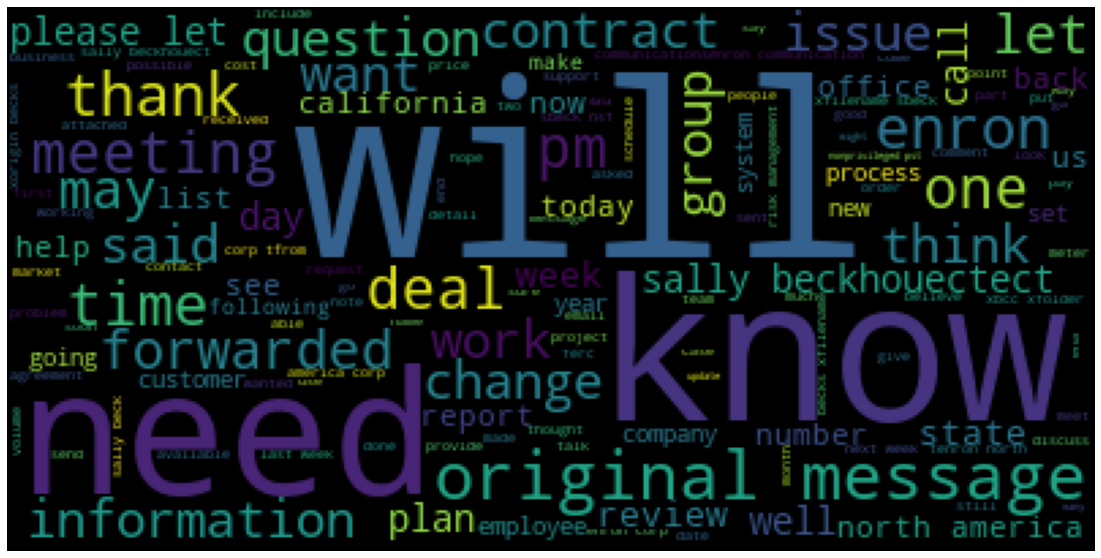

In [243]:
female_cloud = WordCloud(stopwords = STOPWORDS).generate(all_female_words)
plt.figure(figsize = (20,10))
plt.imshow(female_cloud)
plt.axis("off")
plt.show()

In [244]:
all_male_words = ' '.join(list(enron_male_sender['clean_text']))

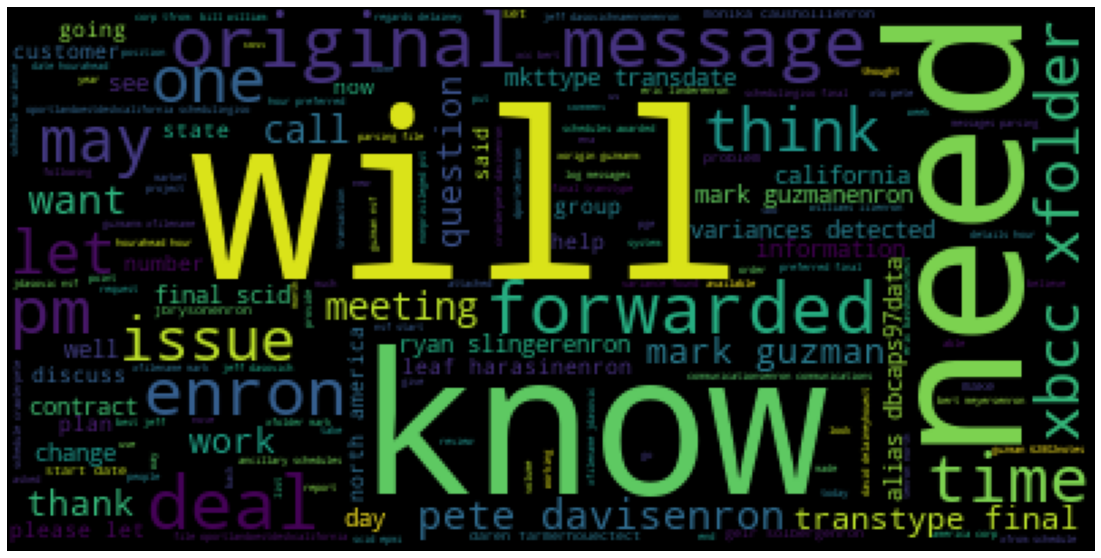

In [245]:
male_cloud = WordCloud(stopwords = STOPWORDS).generate(all_male_words)
plt.figure(figsize = (20,10))
plt.imshow(male_cloud)
plt.axis("off")
plt.show()

## Let's see if we need to be normalizing by the total number of words

In [284]:
enron_known_genders = enron_female_sender.append(enron_male_sender)
enron_known_genders.drop(columns = ['percent_apologetic', 'percent_uncertain', 'percent_appreciative', 'percent_confident'], inplace = True)

In [285]:
enron_known_genders['num_words'] = [len(row) for row in enron_known_genders['text_tokens']]

#we have one outlier that has over 25000 words - we will drop that 
enron_known_genders = enron_known_genders[~(enron_known_genders['num_words'] > 25000)]

In [286]:
enron_known_genders

,index,date,sender,recipient1,subject,sender_name,recipient_name,sender_gender,recipient_gender,clean_text,...,num_uncertain,num_appreciative,num_confident,num_sad,num_familial,num_angry,num_happy,num_holidays,adjInEmail,num_words
0,347,2000-12-13 08:01:00-08:00,rebecca.cantrell@enron.com,phillip.allen@enron.com,Re:,Rebecca,Phillip,female,male,phillip is the value axis on sheet 2 of the s...,...,0,1,1,0,0,0,0,0,22,191
1,407,2000-12-13 05:26:00-08:00,stephanie.miller@enron.com,jeff.dasovich@enron.com,Re: Enron Response to San Diego Request for Ga...,Stephanie,Jeff,female,male,tpkaufmaenron.com richard.sandersenron.com tr...,...,0,0,0,0,0,0,0,0,24,163
2,474,2000-12-12 04:41:00-08:00,christi.nicolay@enron.com,phillip.allen@enron.com,Re: Talking points about California Gas market,Christi,Phillip,female,male,phillipto the extent that we can give chair ho...,...,0,2,2,0,0,0,0,0,17,261
3,506,2000-12-07 01:55:00-08:00,tiffany.miller@enron.com,phillip.allen@enron.com,System Development,Tiffany,Phillip,female,male,can you please review the following systems pr...,...,0,0,0,0,0,0,0,0,6,71
4,679,2000-12-07 01:55:00-08:00,tiffany.miller@enron.com,phillip.allen@enron.com,System Development,Tiffany,Phillip,female,male,can you please review the following systems pr...,...,0,0,0,0,0,0,0,0,6,71
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
38427,67687,2001-11-09 09:28:49-08:00,darren.vanek@enron.com,marie.heard@enron.com,BNP Paribras Master Netting,Darren,Marie,male,female,xorigin heardm xfilename mheard nonprivileged....,...,0,0,0,0,0,0,0,0,8,53
38428,67689,2001-11-12 13:07:30-08:00,steve.van@enron.com,marie.heard@enron.com,RE: Master Collateral/Netting - PSEG Energy Re...,Steve,Marie,male,female,marie please forward to cindy and ask her to ...,...,0,2,0,0,0,0,0,0,14,165
38429,67697,2001-11-14 12:34:04-08:00,edward.sacks@enron.com,marie.heard@enron.com,RE: Master Netting - Tractebel,Edward,Marie,male,female,xorigin heardm xfilename mheard nonprivileged....,...,0,1,0,0,0,0,0,0,11,130
38430,67706,2001-10-31 07:10:47-08:00,morris.clark@enron.com,marie.heard@enron.com,RE: Master Netting Agreement Assignments,Morris,Marie,male,female,marie can you please let me know which of the...,...,0,1,0,0,0,0,0,0,14,137


Text(0, 0.5, 'number of apologetic words')

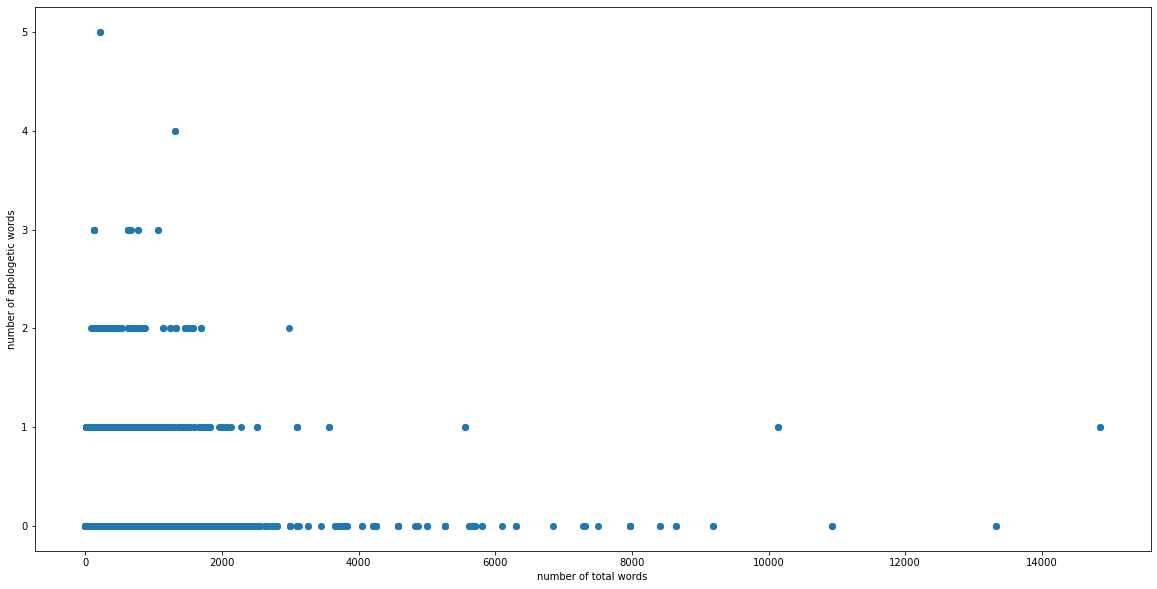

In [248]:
plt.figure(figsize = (20,10))
plt.scatter(enron_known_genders['num_words'], enron_known_genders['num_apologetic'])
plt.xlabel('number of total words')
plt.ylabel('number of apologetic words')

Text(0, 0.5, 'number of uncertain words')

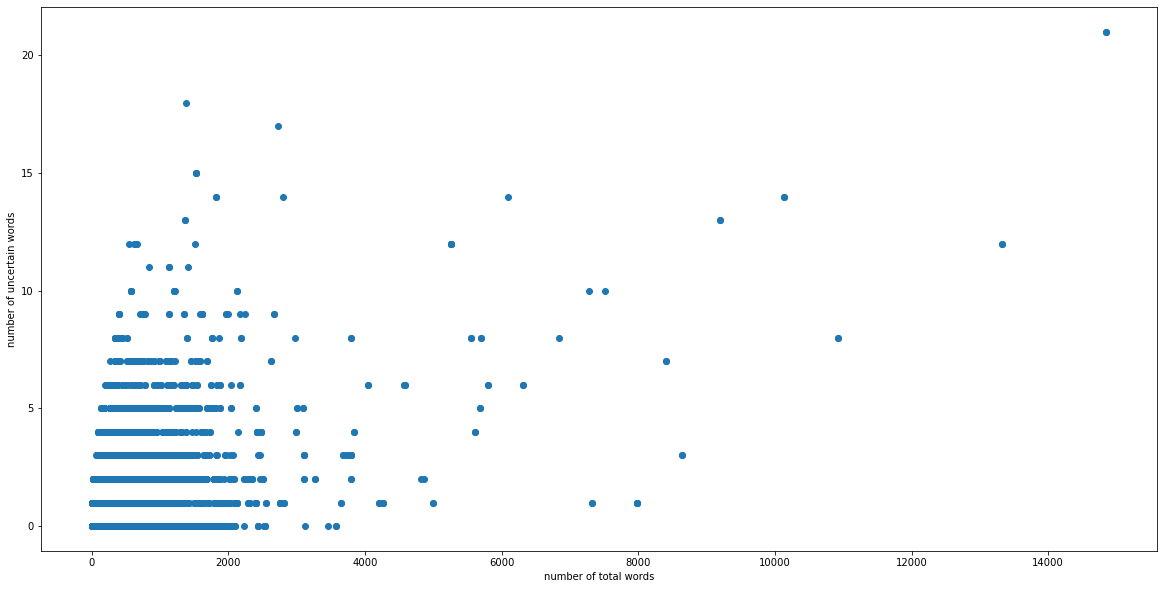

In [249]:
plt.figure(figsize = (20,10))
plt.scatter(enron_known_genders['num_words'], enron_known_genders['num_uncertain'])
plt.xlabel('number of total words')
plt.ylabel('number of uncertain words')

Text(0, 0.5, 'number of appreciative words')

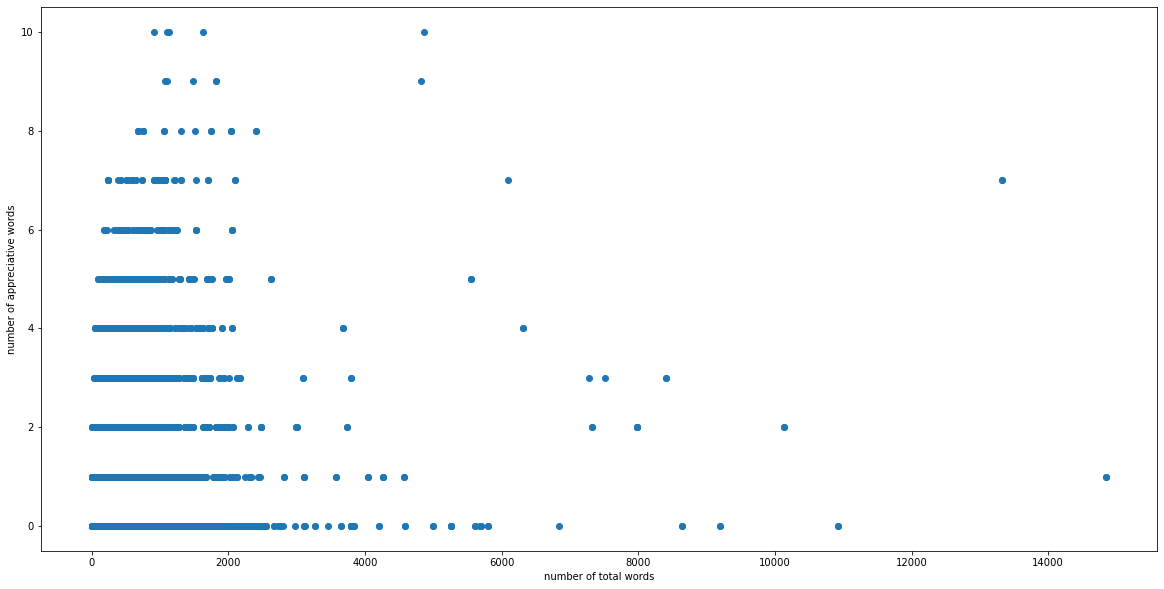

In [250]:
plt.figure(figsize = (20,10))
plt.scatter(enron_known_genders['num_words'], enron_known_genders['num_appreciative'])
plt.xlabel('number of total words')
plt.ylabel('number of appreciative words')

Text(0, 0.5, 'number of confident words')

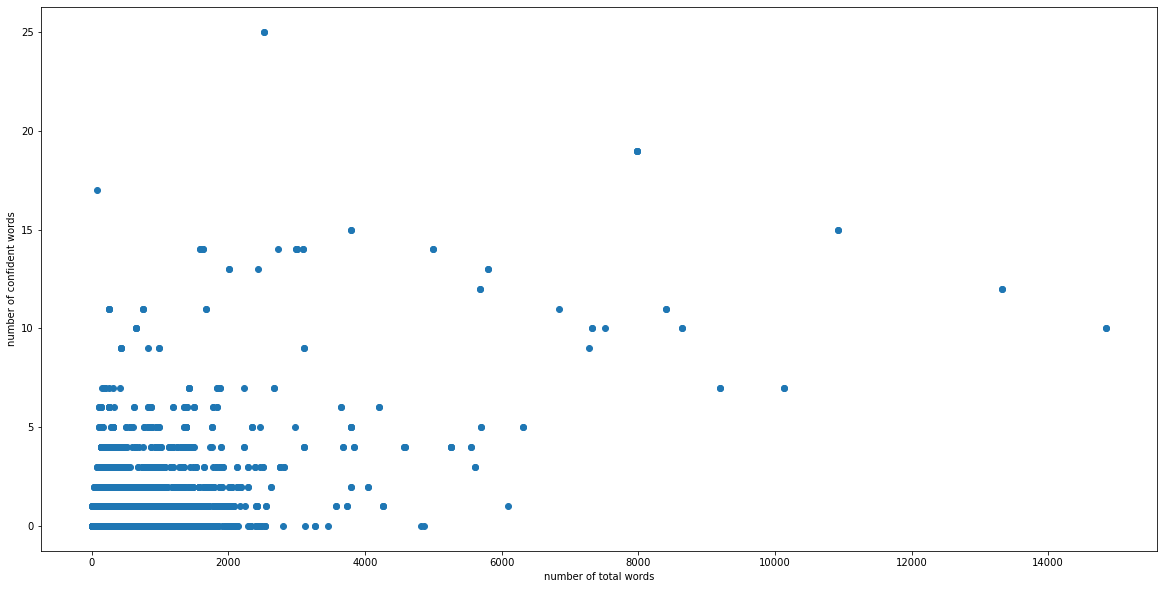

In [251]:
plt.figure(figsize = (20,10))
plt.scatter(enron_known_genders['num_words'], enron_known_genders['num_confident'])
plt.xlabel('number of total words')
plt.ylabel('number of confident words')

We don't see very much correlation above with the total number of words, so we will not standardize our values by that 

## Now let's start on the logistic regression

In [252]:
enron_known_genders.head()

,index,date,sender,recipient1,subject,sender_name,recipient_name,sender_gender,recipient_gender,clean_text,...,num_uncertain,num_appreciative,num_confident,num_sad,num_familial,num_angry,num_happy,num_holidays,adjInEmail,num_words
0,347,2000-12-13 08:01:00-08:00,rebecca.cantrell@enron.com,phillip.allen@enron.com,Re:,Rebecca,Phillip,female,male,phillip is the value axis on sheet 2 of the s...,...,0,1,1,0,0,0,0,0,22,191
1,407,2000-12-13 05:26:00-08:00,stephanie.miller@enron.com,jeff.dasovich@enron.com,Re: Enron Response to San Diego Request for Ga...,Stephanie,Jeff,female,male,tpkaufmaenron.com richard.sandersenron.com tr...,...,0,0,0,0,0,0,0,0,24,163
2,474,2000-12-12 04:41:00-08:00,christi.nicolay@enron.com,phillip.allen@enron.com,Re: Talking points about California Gas market,Christi,Phillip,female,male,phillipto the extent that we can give chair ho...,...,0,2,2,0,0,0,0,0,17,261
3,506,2000-12-07 01:55:00-08:00,tiffany.miller@enron.com,phillip.allen@enron.com,System Development,Tiffany,Phillip,female,male,can you please review the following systems pr...,...,0,0,0,0,0,0,0,0,6,71
4,679,2000-12-07 01:55:00-08:00,tiffany.miller@enron.com,phillip.allen@enron.com,System Development,Tiffany,Phillip,female,male,can you please review the following systems pr...,...,0,0,0,0,0,0,0,0,6,71


In [253]:
enron_known_genders['sender_dummy'] = [1 if (val == 'female') else 0 for val in enron_known_genders['sender_gender'] ]

In [337]:
all_possible_features=  ['num_apologetic','num_uncertain', 'num_appreciative', 'num_confident', 'num_sad', 'num_familial', 'num_angry', 'num_happy', 'num_holidays', 'adjInEmail','num_words']

Let's start with just a basic model that only considers the number of words - we saw that the average number of words in females' emails was greater, so maybe that will be somewhat accurate!

In [254]:
X_train, X_test, Y_train, Y_test = train_test_split(enron_known_genders[['num_words']], enron_known_genders['sender_dummy'], test_size=0.2, random_state=34)

In [255]:
logist_simple = LogisticRegression(random_state = 0).fit(X_train, Y_train)

In [256]:
predicted_simple = logist_simple.predict(X_test)
predicted_probs_simple = logist_simple.predict_proba(X_test)
print(logist_simple.score(X_test,Y_test))

0.741988102091729


In [257]:
confusion_matrix(predicted_simple,Y_test)

array([[7723, 2683],
       [   6,   10]], dtype=int64)

In [258]:
print(logist_simple.coef_)

[[0.00037652]]


Hmmm.... that isn't a very high weight... let's try some more features

In [261]:
X_train, X_test, Y_train, Y_test = train_test_split(enron_known_genders[['num_apologetic', 'num_uncertain','num_appreciative', 'num_confident', 'num_sad', 'num_familial','num_angry', 'num_happy', 'num_holidays', 'adjInEmail', 'num_words']], enron_known_genders['sender_dummy'], test_size=0.2, random_state=34)

In [262]:
logist = LogisticRegression(random_state = 0).fit(X_train, Y_train)

C:\Users\baile\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [263]:
predicted_genders = logist.predict(X_test)
predicted_probs = logist.predict_proba(X_test)
print(logist.score(X_test,Y_test))

0.7402609863749761


In [264]:
confusion_matrix(predicted_genders,Y_test)

array([[7619, 2597],
       [ 110,   96]], dtype=int64)

In [265]:
print(logist.coef_)

[[ 0.20827098 -0.04696162  0.32681741  0.03636931  0.02528603  0.23988367
  -0.02827946  0.22347325  0.14239775 -0.00645523  0.00066139]]


HMMMM...looks like num_words still isn't very correlated. Let's try without it

In [266]:
X_train, X_test, Y_train, Y_test = train_test_split(enron_known_genders[['num_apologetic', 'num_uncertain','num_appreciative', 'num_confident', 'num_sad', 'num_familial','num_angry', 'num_happy', 'num_holidays', 'adjInEmail']], enron_known_genders['sender_dummy'], test_size=0.2, random_state=34)

In [267]:
logist = LogisticRegression(random_state = 0).fit(X_train, Y_train)

C:\Users\baile\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [268]:
predicted_genders = logist.predict(X_test)
predicted_probs = logist.predict_proba(X_test)
print(logist.score(X_test,Y_test))

0.7399731337555172


In [269]:
confusion_matrix(predicted_genders,Y_test)

array([[7610, 2591],
       [ 119,  102]], dtype=int64)

In [270]:
print(logist.coef_)

[[ 2.50135894e-01 -3.18267065e-02  3.34246988e-01  3.62664803e-02
   5.45179530e-02  1.90616404e-01 -5.71670137e-02  2.53005560e-01
   1.51126531e-01 -2.19225516e-04]]


In [ ]:
'num_apologetic','num_appreciative', 'num_familial', 'num_happy', 'num_holidays'

What if we only look at the features that have larger weights?

In [271]:
X_train, X_test, Y_train, Y_test = train_test_split(enron_known_genders[['num_apologetic','num_appreciative', 'num_familial', 'num_happy', 'num_holidays']], enron_known_genders['sender_dummy'], test_size=0.2, random_state=34)

In [272]:
logist = LogisticRegression(random_state = 0).fit(X_train, Y_train)

In [273]:
predicted_genders = logist.predict(X_test)
predicted_probs = logist.predict_proba(X_test)
print(logist.score(X_test,Y_test))

0.7404528881212818


In [274]:
confusion_matrix(predicted_genders,Y_test)

array([[7634, 2610],
       [  95,   83]], dtype=int64)

In [275]:
print(logist.coef_)

[[0.23220615 0.32833614 0.1906565  0.23483382 0.14709105]]


That was our best one yet!!! Let's stop there for now

In [334]:
#enron_known_genders.to_csv('final_enron_gender.csv')